In [9]:
!pip install "gymnasium[mujoco]"
!pip install mpi4py


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [10]:
import os
import subprocess
import torch
from matplotlib import pyplot as plt
import gymnasium as gym
import numpy as np
import pandas as pd

In [11]:
env_file = 'model_downloader.py'
env_url = "https://raw.githubusercontent.com/alibaniasad1999/master-thesis/main/Code/Python/utils/model_downloader.py"

if not os.path.isfile(env_file):
    print(f"Downloading {env_file} ...")
    subprocess.run(
        ['wget', '-q', '-O', env_file, env_url],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )
    print(f"{env_file} downloaded.")
else:
    print(f"{env_file} already exists.")

from model_downloader import download_file, download_everything

trajectory = download_everything('sac, TBP, zs_sac, sac_models, zs_sac_models')

from Zero_Sum_SAC import ZS_SAC
from utils.run_utils import setup_logger_kwargs
from SAC import SAC
import TBP
from TBP import ThreeBodyEnv
import torch

model_downloader.py already exists.
trajectory.csv already exists.
Trajectory head:
   0.87018  -0.059444  0  -0.010472  -0.17514  0.1
0  0.87018  -0.059540  0  -0.010536  -0.17494    0
1  0.87017  -0.059636  0  -0.010600  -0.17474    0
2  0.87017  -0.059732  0  -0.010664  -0.17454    0
3  0.87016  -0.059828  0  -0.010728  -0.17434    0
4  0.87015  -0.059924  0  -0.010793  -0.17414    0
Data shape: (9999, 6)
TBP.py already exists.
SAC.py already exists.
Directory 'model' already exists and is not empty.
model/actor_cpu.pth already exists.
model/q1_cpu.pth already exists.
model/q2_cpu.pth already exists.
Zero_Sum_SAC.py already exists.
Directory 'model_zs' already exists and is not empty.
model_zs/actor_cpu.pth already exists.
model_zs/actor_1_cpu.pth already exists.
model_zs/q1_cpu.pth already exists.
model_zs/q1_1_cpu.pth already exists.
model_zs/q2_cpu.pth already exists.
model_zs/q2_1_cpu.pth already exists.


In [12]:
# Helper function to create the environment
def make_env(error_range=0.01, final_range=0.001):
    return ThreeBodyEnv(trajectory, error_range=error_range, final_range=final_range)

Logging data to /tmp/experiments/1756190884/progress.txt
Saving config:

{
    "ac_kwargs_class":	{
        "hidden_sizes":	[
            64,
            64
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "alpha":	0.2,
    "batch_size":	1024,
    "device_class":	"cpu",
    "env_fn":	"<function <lambda> at 0x167b52480>",
    "epochs":	100,
    "gamma":	0.99,
    "logger_kwargs":	null,
    "lr":	0.001,
    "max_ep_len":	30000,
    "num_test_episodes":	10,
    "num_updates":	10,
    "polyak":	0.995,
    "replay_size":	1000000,
    "save_freq":	1,
    "seed":	0,
    "self":	{
        "<SAC.SAC object at 0x16043db50>":	{
            "ac_kwargs":	{
                "hidden_sizes":	[
                    64,
                    64
                ]
            },
            "actor_critic":	"MLPActorCritic",
            "alpha":	0.2,
            "batch_size":	1024,
            "device":	"cpu",
            "env_fn":	"<function <lambda> at 0x167b52480>",
            "epochs":	100,
    

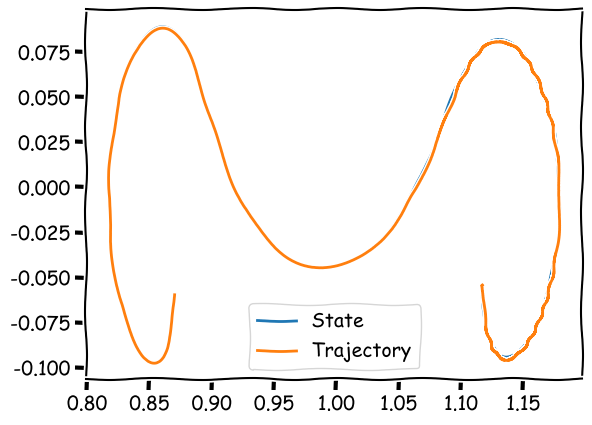

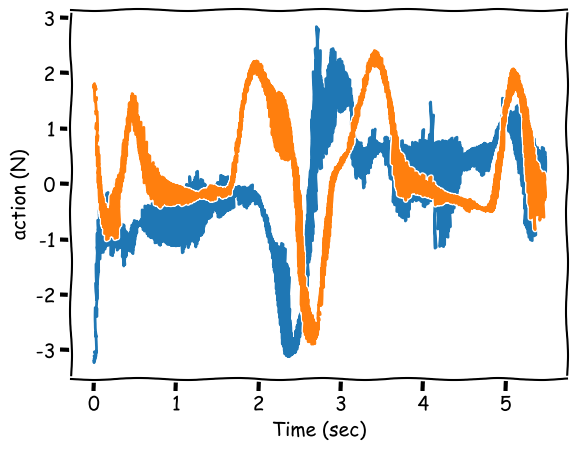

done 🥺
second player was in the game


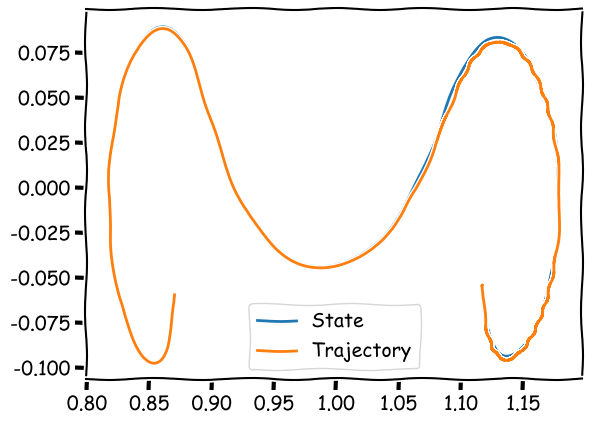

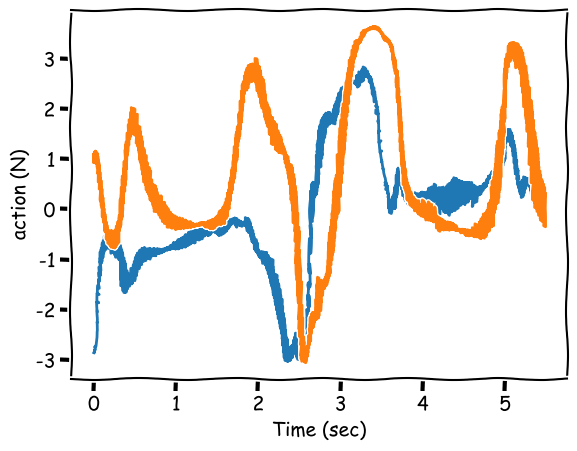

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(colorize(f"Device is {device}! 🥰😎", 'green', bold=True))
# Define variables directly
env = ThreeBodyEnv(trajectory)
hid = 64
l = 2
gamma = 0.99
seed = 0
epochs = 50
exp_name = 'sac'
steps_per_epoch_=30000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ac_kwargs = dict(hidden_sizes=[hid]*l)
states_array = []
# logger_kwargs = setup_logger_kwargs(exp_name, seed)
reward_array=[]

sac = SAC(lambda : ThreeBodyEnv(trajectory, error_range=0.01, final_range=0.001), epochs=100, device_class=device, ac_kwargs_class=ac_kwargs, steps_per_epoch=steps_per_epoch_, batch_size=1024, start_steps=5000, update_after=1000, update_every=2000)

zs_sac = ZS_SAC(lambda : ThreeBodyEnv(trajectory, error_range=0.01, final_range=0.001), epochs=100, device_class=device, ac_kwargs_class=ac_kwargs, steps_per_epoch=steps_per_epoch_, batch_size=1024, start_steps=5000, update_after=1000, update_every=2000)


zs_sac.load(filepath='model_zs/')
sac.load()


# test sac agent (not trained)
zs_sac.test(fun_mode=True, deterministic=True, save_data=False)
sac.test(fun_mode=True, deterministic=True, save_data=False)

# zs_sac.test(fun_mode=True)
zs_sac.env.second_player = False
sac.env.second_player = False

In [14]:
class DynamicsPerturbationWrapper(gym.Wrapper):
    """
    Gym environment wrapper that introduces dynamics perturbation (model mismatch) to the environment.
    The dynamics of the environment are randomly perturbed during each episode.
    This wrapper supports the Gymnasium API where:
      - reset returns: (observation, info)
      - step returns: (observation, reward, terminated, truncated, info)
    """

    def __init__(self, env, perturbation_std=0.05, perturb_reward_std=0.01):
        super(DynamicsPerturbationWrapper, self).__init__(env)
        self.perturbation_std = perturbation_std  # Standard deviation for state transition perturbation
        self.perturb_reward_std = perturb_reward_std  # Standard deviation for reward perturbation

    def reset(self, **kwargs):
        result = self.env.reset(**kwargs)
        if isinstance(result, tuple):
            obs, info = result
            return obs, info
        else:
            return result

    def step(self, action):
        """
        Introduces random perturbations in the state transition and reward functions.
        """
        # Apply perturbation to the state transition and reward
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Perturb the state transition (i.e., modify the state)
        obs = self._perturb_state(obs)

        # Perturb the reward function (i.e., modify the reward)
        reward = self._perturb_reward(reward)

        return obs, reward, terminated, truncated, info

    def _perturb_state(self, state):
        """
        Perturbs the state with Gaussian noise.
        """
        state = np.array(state)
        perturbation = np.random.normal(0, self.perturbation_std, size=state.shape)
        return np.clip(state + perturbation, self.env.observation_space.low, self.env.observation_space.high)

    def _perturb_reward(self, reward):
        """
        Perturbs the reward function with Gaussian noise.
        """
        return reward + np.random.normal(0, self.perturb_reward_std)


def make_env_dynamics_perturbation(error_range=0.01, final_range=0.001, perturbation_std=0.05, perturb_reward_std=0.01):
    """
    Creates the ThreeBodyEnv wrapped with dynamics perturbation.
    """
    env = ThreeBodyEnv(trajectory, error_range=error_range, final_range=final_range)
    return DynamicsPerturbationWrapper(env, perturbation_std=perturbation_std, perturb_reward_std=perturb_reward_std)


In [15]:
def run_episode(agent, env_fn, max_steps=10000):
    """
    Run one episode using the given agent and environment function.
    Adapted for Gymnasium (reset returns (obs, info) and step returns five outputs).

    Returns:
        total_reward, avg_error_per_step, num_of_fails, avg_action_magnitude_per_step
    """
    env = env_fn()

    obs, _ = env.reset()  # Gymnasium reset returns (obs, info)
    total_reward = 0.0
    total_error = 0.0
    num_of_fails = 0
    total_actions = 0.0
    steps = 0
    done = False
    env.second_player = False

    while not done and steps < max_steps:
        action = agent.ac.act(torch.as_tensor(obs, dtype=torch.float32, device=device), deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        steps += 1
        # match actuator/initial metrics
        total_error = np.dot(obs[0:2], obs[0:2])**0.5
        total_actions += np.dot(action, action)**0.5
        if done and reward < 0:
            num_of_fails += 1

    env.close()
    return total_reward, total_error/steps, num_of_fails, total_actions/steps


def evaluate_agent(agent, env_fn, num_episodes=20, max_steps=10000):
    """
    Evaluate the agent over multiple episodes and collect cumulative rewards, errors, fails, and actions.
    """
    returns = []
    errors = []
    fails = []
    actions = []
    for i in range(num_episodes):
        ret, error, fail, action = run_episode(agent, env_fn, max_steps)
        returns.append(ret)
        errors.append(error)
        fails.append(fail)
        actions.append(action)
        print(f"{i} of {num_episodes}")
    return returns, errors, fails, actions


In [16]:

# Number of episodes for evaluation
num_episodes = 10

# Update the agents' environment function to use dynamics perturbation (model mismatch)
zs_sac.env_fn = lambda: make_env_dynamics_perturbation(perturbation_std=0.05, perturb_reward_std=0.01)
sac.env_fn = lambda: make_env_dynamics_perturbation(perturbation_std=0.05, perturb_reward_std=0.01)

# Evaluate Zero-Sum DDPG and Standard DDPG agents with dynamics perturbation
returns_zs_dynamics_perturbation, total_error_zs, num_of_fails_zs, total_actions_zs \
    = evaluate_agent(zs_sac, zs_sac.env_fn, num_episodes=num_episodes)
returns_std_dynamics_perturbation, total_error_std, num_of_fails_std, total_actions_std \
    = evaluate_agent(sac, sac.env_fn, num_episodes=num_episodes)


[-0.01000891  0.0002048  -0.04834202  0.00725724]
idx 0.09998 state 0.0498982800772603
too much error 🥲😱
second player was in the game
0 of 10
[-0.00973948  0.00245937 -0.04380049  0.01203175]
idx 0.09998 state 0.046520444322488023
too much error 🥲😱
second player was in the game
1 of 10
[-0.00987712  0.00167177 -0.0455173   0.01047752]
idx 0.09998 state 0.0477698115583662
too much error 🥲😱
second player was in the game
2 of 10
[-0.00969989  0.00277327 -0.04316951  0.01267811]
idx 0.09998 state 0.04610986908739034
too much error 🥲😱
second player was in the game
3 of 10
[-0.00963985  0.00283367 -0.04287091  0.01273233]
idx 0.09998 state 0.045836484654507466
too much error 🥲😱
second player was in the game
4 of 10
[-0.00947242  0.00325063 -0.04164115  0.01340138]
idx 0.09998 state 0.04487622517924767
too much error 🥲😱
second player was in the game
5 of 10
[-0.00957403  0.00306374 -0.04231435  0.01309857]
idx 0.09998 state 0.0454216405136462
too much error 🥲😱
second player was in the game
6

Zero-Sum DDPG with Dynamics Perturbation Average Return: -4348.01193658565
Standard DDPG with Dynamics Perturbation Average Return: -4886.399580650407


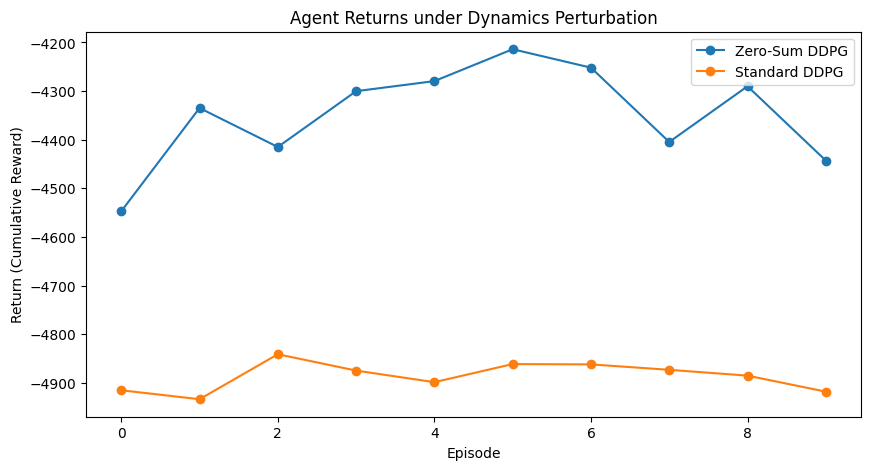

In [17]:
# Calculate and print average returns
avg_return_zs_dynamics_perturbation = np.mean(returns_zs_dynamics_perturbation)
avg_return_std_dynamics_perturbation = np.mean(returns_std_dynamics_perturbation)

print("Zero-Sum DDPG with Dynamics Perturbation Average Return:", avg_return_zs_dynamics_perturbation)
print("Standard DDPG with Dynamics Perturbation Average Return:", avg_return_std_dynamics_perturbation)

# Plot the returns for visual comparison
plt.figure(figsize=(10, 5))
plt.plot(returns_zs_dynamics_perturbation, marker='o', label='Zero-Sum DDPG')
plt.plot(returns_std_dynamics_perturbation, marker='o', label='Standard DDPG')
plt.xlabel('Episode')
plt.ylabel('Return (Cumulative Reward)')
plt.title('Agent Returns under Dynamics Perturbation')
plt.legend()
plt.show()


Zero-Sum DDPG with Dynamics Perturbation Average Error: 0.0002556140038526643
Standard DDPG with Dynamics Perturbation Average Error: 0.00038084195998123283


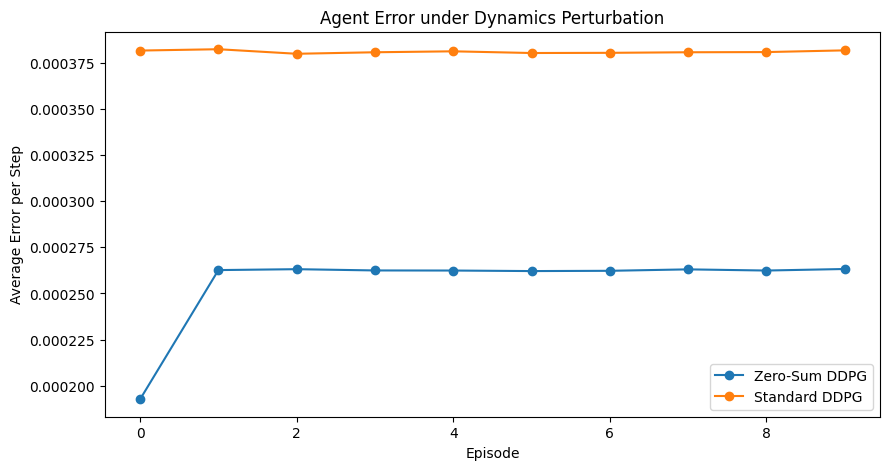

Zero-Sum DDPG with Dynamics Perturbation Average Action Magnitude: 1.160354555641675
Standard DDPG with Dynamics Perturbation Average Action Magnitude: 1.9934796156580556


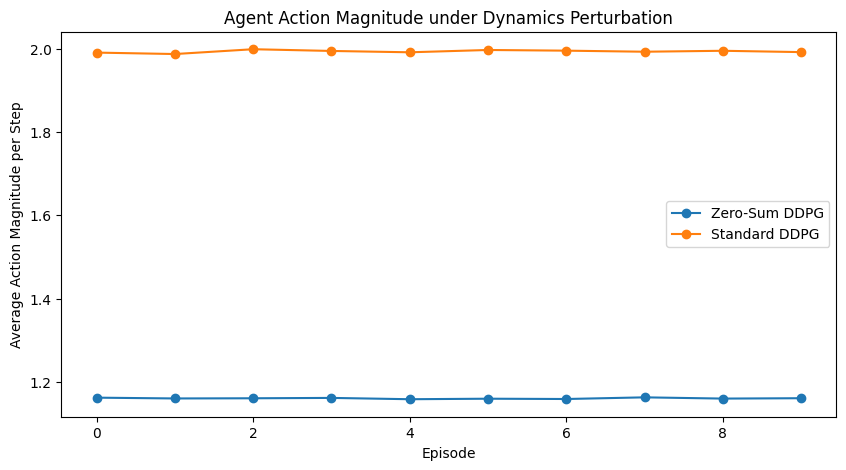

Zero-Sum DDPG with Dynamics Perturbation Average Number of Fails per Episode: 1.0
Standard DDPG with Dynamics Perturbation Average Number of Fails per Episode: 1.0


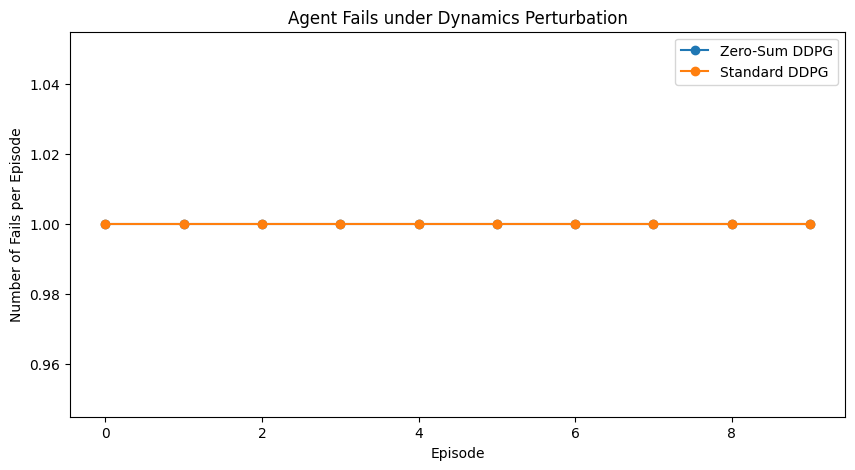

In [18]:
# Additional metrics: average error, action magnitude, and fails
avg_total_error_zs = np.mean(total_error_zs)
avg_total_error_std = np.mean(total_error_std)
print("Zero-Sum DDPG with Dynamics Perturbation Average Error:", avg_total_error_zs)
print("Standard DDPG with Dynamics Perturbation Average Error:", avg_total_error_std)

plt.figure(figsize=(10, 5))
plt.plot(total_error_zs, marker='o', label='Zero-Sum DDPG')
plt.plot(total_error_std, marker='o', label='Standard DDPG')
plt.xlabel('Episode')
plt.ylabel('Average Error per Step')
plt.title('Agent Error under Dynamics Perturbation')
plt.legend()
plt.show()

avg_total_actions_zs = np.mean(total_actions_zs)
avg_total_actions_std = np.mean(total_actions_std)
print("Zero-Sum DDPG with Dynamics Perturbation Average Action Magnitude:", avg_total_actions_zs)
print("Standard DDPG with Dynamics Perturbation Average Action Magnitude:", avg_total_actions_std)

plt.figure(figsize=(10, 5))
plt.plot(total_actions_zs, marker='o', label='Zero-Sum DDPG')
plt.plot(total_actions_std, marker='o', label='Standard DDPG')
plt.xlabel('Episode')
plt.ylabel('Average Action Magnitude per Step')
plt.title('Agent Action Magnitude under Dynamics Perturbation')
plt.legend()
plt.show()

avg_num_of_fails_zs = np.mean(num_of_fails_zs)
avg_num_of_fails_std = np.mean(num_of_fails_std)
print("Zero-Sum DDPG with Dynamics Perturbation Average Number of Fails per Episode:", avg_num_of_fails_zs)
print("Standard DDPG with Dynamics Perturbation Average Number of Fails per Episode:", avg_num_of_fails_std)

plt.figure(figsize=(10, 5))
plt.plot(num_of_fails_zs, marker='o', label='Zero-Sum DDPG')
plt.plot(num_of_fails_std, marker='o', label='Standard DDPG')
plt.xlabel('Episode')
plt.ylabel('Number of Fails per Episode')
plt.title('Agent Fails under Dynamics Perturbation')
plt.legend()
plt.show()


In [19]:
# Normalized evaluation results (consistent with other notebooks)
print("Normalized Zero-Sum DDPG with Dynamics Perturbation Average Return:", avg_return_zs_dynamics_perturbation/1000)
print("Normalized Standard DDPG with Dynamics Perturbation Average Return:", avg_return_std_dynamics_perturbation/1000)
print("Normalized Zero-Sum DDPG with Dynamics Perturbation Average Error:", avg_total_error_zs*1000)
print("Normalized Standard DDPG with Dynamics Perturbation Average Error:", avg_total_error_std*1000)
print("Normalized Zero-Sum DDPG with Dynamics Perturbation Average Action Magnitude:", avg_total_actions_zs)
print("Normalized Standard DDPG with Dynamics Perturbation Average Action Magnitude:", avg_total_actions_std)
print("Normalized Zero-Sum DDPG with Dynamics Perturbation Average Number of Fails per Episode:", avg_num_of_fails_zs/10)
print("Normalized Standard DDPG with Dynamics Perturbation Average Number of Fails per Episode:", avg_num_of_fails_std/10)


Normalized Zero-Sum DDPG with Dynamics Perturbation Average Return: -4.3480119365856496
Normalized Standard DDPG with Dynamics Perturbation Average Return: -4.886399580650407
Normalized Zero-Sum DDPG with Dynamics Perturbation Average Error: 0.2556140038526643
Normalized Standard DDPG with Dynamics Perturbation Average Error: 0.3808419599812328
Normalized Zero-Sum DDPG with Dynamics Perturbation Average Action Magnitude: 1.160354555641675
Normalized Standard DDPG with Dynamics Perturbation Average Action Magnitude: 1.9934796156580556
Normalized Zero-Sum DDPG with Dynamics Perturbation Average Number of Fails per Episode: 0.1
Normalized Standard DDPG with Dynamics Perturbation Average Number of Fails per Episode: 0.1


In [20]:
# print for latex table
print(f"""${avg_return_std_dynamics_perturbation/1000:.2f}$ & ${avg_return_zs_dynamics_perturbation/1000:.2f}$ & ${avg_total_error_std*1000:.2f}$ & ${avg_total_error_zs*1000:.2f}$ & ${avg_total_actions_zs:.2f}$ & ${avg_total_actions_zs:.2f}$ & ${avg_num_of_fails_std:.2f}$ & ${avg_num_of_fails_zs:.2f}$
""")

$-4.89$ & $-4.35$ & $0.38$ & $0.26$ & $1.16$ & $1.16$ & $1.00$ & $1.00$



/var/folders/cf/x6zpxdwn2dg40q0c0r418f7c0000gp/T/ipykernel_19841/4289535761.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Zero-Sum DDPG', 'Standard DDPG'])


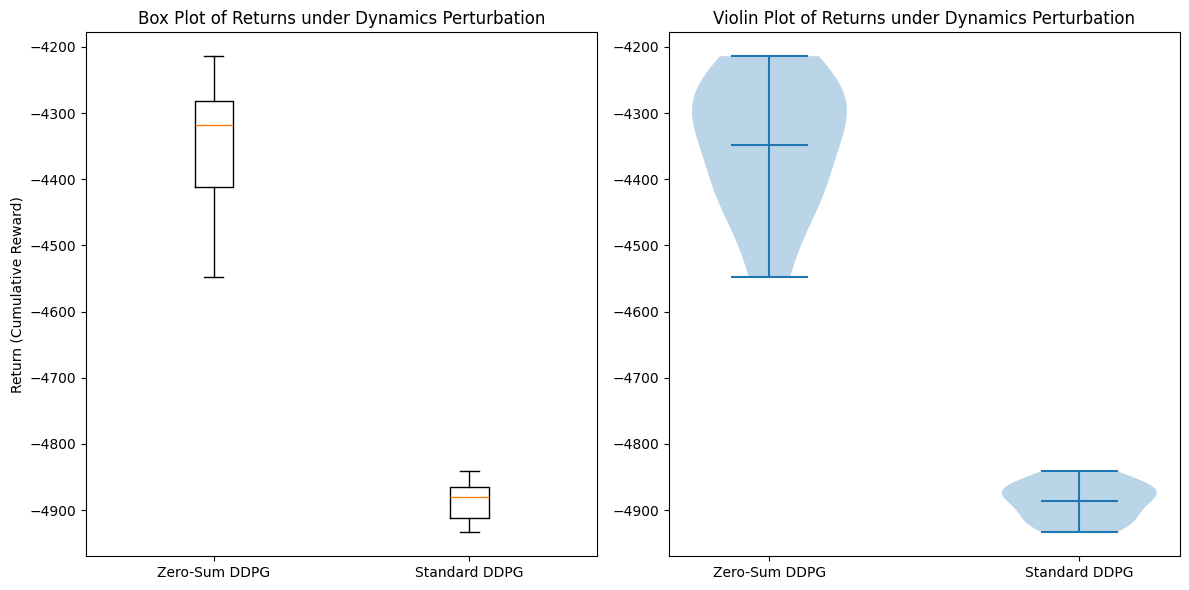

In [21]:
# Box and violin plots of returns
data = [returns_zs_dynamics_perturbation, returns_std_dynamics_perturbation]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.boxplot(data, labels=['Zero-Sum DDPG', 'Standard DDPG'])
plt.title('Box Plot of Returns under Dynamics Perturbation')
plt.ylabel('Return (Cumulative Reward)')

plt.subplot(1, 2, 2)
plt.violinplot(data, showmeans=True)
plt.xticks([1, 2], ['Zero-Sum DDPG', 'Standard DDPG'])
plt.title('Violin Plot of Returns under Dynamics Perturbation')

plt.tight_layout()
plt.show()


In [22]:
# Save returns to CSV
df = pd.DataFrame(np.array(data).T, columns=['Zero-Sum DDPG', 'Standard DDPG'])
df.head()

,Zero-Sum DDPG,Standard DDPG
0,-4547.180421,-4915.303901
1,-4334.824704,-4933.737052
2,-4414.965536,-4841.231665
3,-4300.194342,-4874.841446
4,-4279.507670,-4898.677764


In [23]:
df.to_csv('evaluation_returns.csv', index=False)